# Восканян Юрий, КИ22-17/1б
### Практическая работа 3. Задача классификации. Вариант 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree

## 1.Загрузка данных для обучения и теста

In [3]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
...,...,...,...,...,...,...,...,...,...,...,...
643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S


## 2.Предварительная обработка данных

In [4]:
# Проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 486 to 461
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  534 non-null    int64  
 1   Pclass    534 non-null    int64  
 2   Name      534 non-null    object 
 3   Sex       534 non-null    object 
 4   Age       432 non-null    float64
 5   SibSp     534 non-null    int64  
 6   Parch     534 non-null    int64  
 7   Ticket    534 non-null    object 
 8   Fare      534 non-null    float64
 9   Cabin     120 non-null    object 
 10  Embarked  534 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 50.1+ KB


In [5]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,534.000000,534.000000,432.000000,534.000000,534.00000,534.000000
mean,0.391386,2.327715,29.612662,0.548689,0.38015,32.780453
std,0.488518,0.839514,14.740699,1.206793,0.81936,52.203248
min,0.000000,1.000000,0.420000,0.000000,0.00000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.00000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.00000,13.000000
75%,1.000000,3.000000,38.250000,1.000000,0.00000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.00000,512.329200


<Axes: >

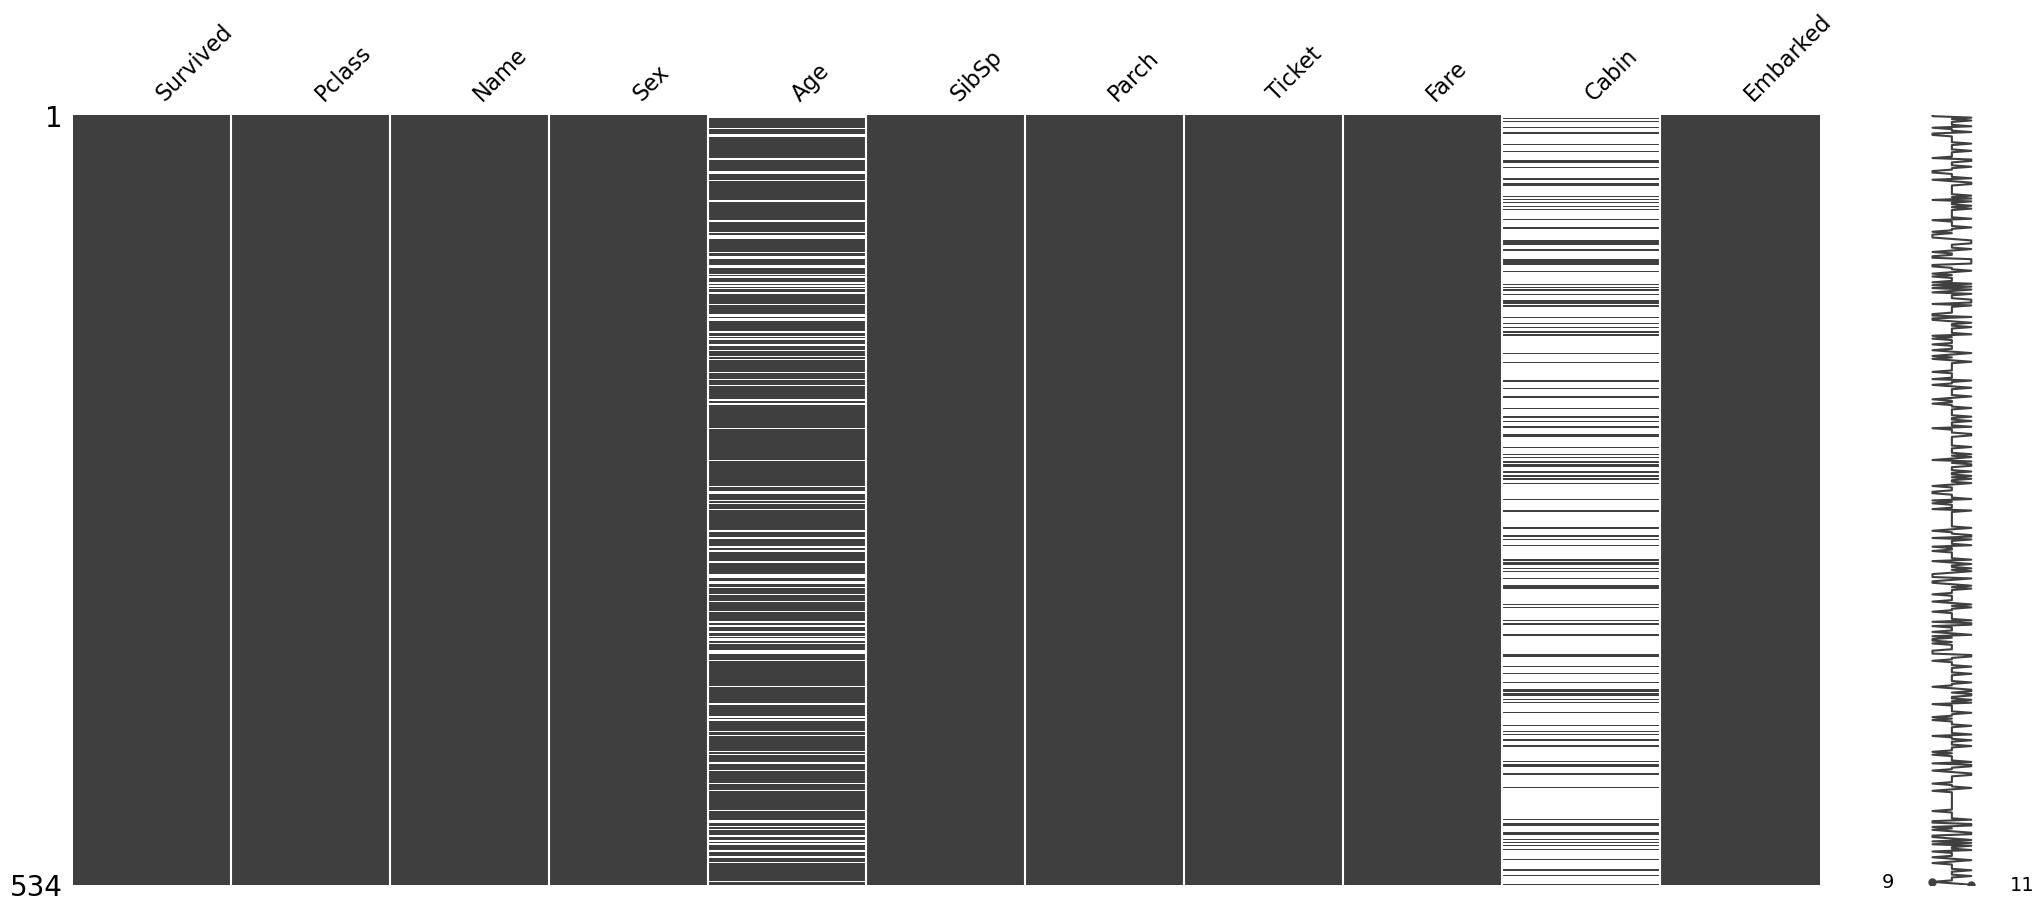

In [6]:
# Проверка пропусков
missingno.matrix(df)

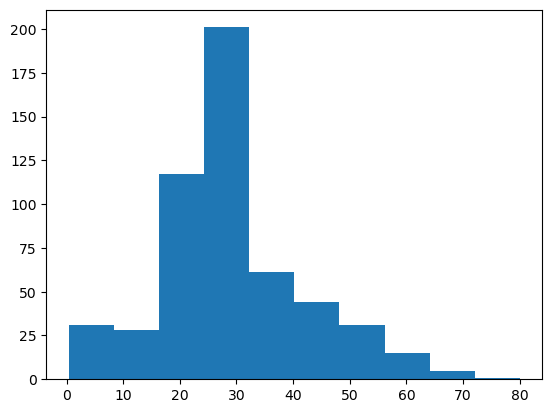

In [7]:
imp = KNNImputer(missing_values=np.nan)
df['Age'] = df['Age'].fillna(df['Age'].mean())
plt.hist(df['Age'])
plt.show()

In [8]:
# Удалим столбец Cabin
del df['Cabin']

In [9]:
# Удалим не нужные столбцы из data frame
df.drop(columns=['Name', 'Ticket', 'Fare'], inplace=True)

<Axes: >

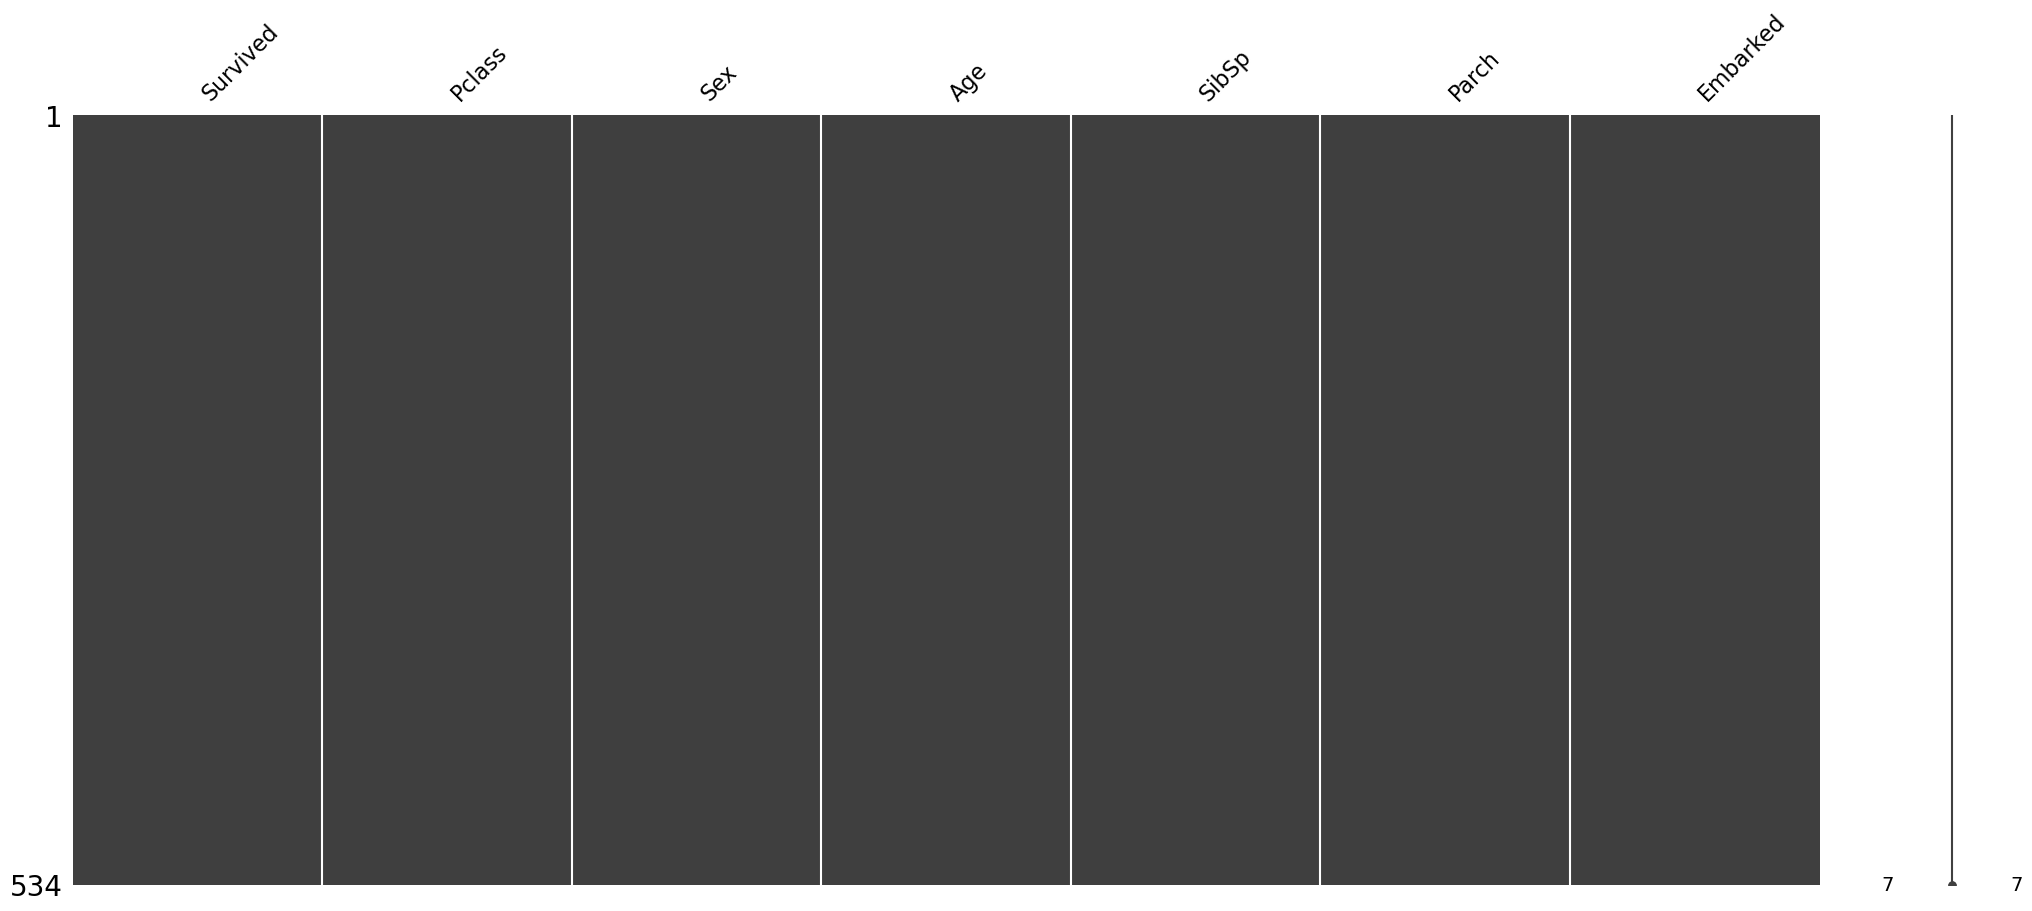

In [10]:
missingno.matrix(df)

In [11]:
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
standard_scaler = StandardScaler()

In [12]:
# Удаление выбросов
def sigmaclip(d, s, low=4, high=4):
    mean = d[s].mean()
    std = d[s].std()
    return d[(d[s].isna()) | ((d[s] >= mean - std*low) & (d[s] <= mean + std*high))]

# df = sigmaclip(df, 'Fare')
# Применение OneHotEncoder к категориальным переменным
categorical_variables = ['Sex', 'Embarked']
transformed = one_hot_encoder.fit_transform(df[categorical_variables])
encoded = pd.DataFrame(transformed, index=df.index)
encoded.columns = one_hot_encoder.get_feature_names_out()
df = df.join(encoded)
df.drop(columns=['Sex', 'Embarked'], inplace=True)



In [13]:
# применение standard_scaler к числовым переменным
numeric_variables = ['Pclass', 'Age', 'SibSp', 'Parch']
df[numeric_variables] = standard_scaler.fit_transform(df[numeric_variables])

df.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
486,0,0.801553,5.365425e-16,2.033165,0.757215,0.0,0.0,1.0
426,0,0.801553,5.365425e-16,-0.455094,-0.464395,1.0,0.0,1.0
780,1,-1.583011,1.010900e+00,-0.455094,0.757215,0.0,0.0,1.0
248,1,-0.390729,-4.238213e-01,-0.455094,1.978825,0.0,0.0,1.0
184,1,-0.390729,-2.160589e+00,1.203746,0.757215,1.0,0.0,1.0


## 3.Построение моделей классификаторов с параметрами, подобранными на перекрестной проверке (cross validation). 

In [14]:
y = df['Survived']
X = df.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Применение семплирования к данным
smote = SMOTE()
rs = RandomUnderSampler()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree_accuracy = accuracy_score(y_train, tree.predict(X_train))

tree_accuracy=0.9543478260869566


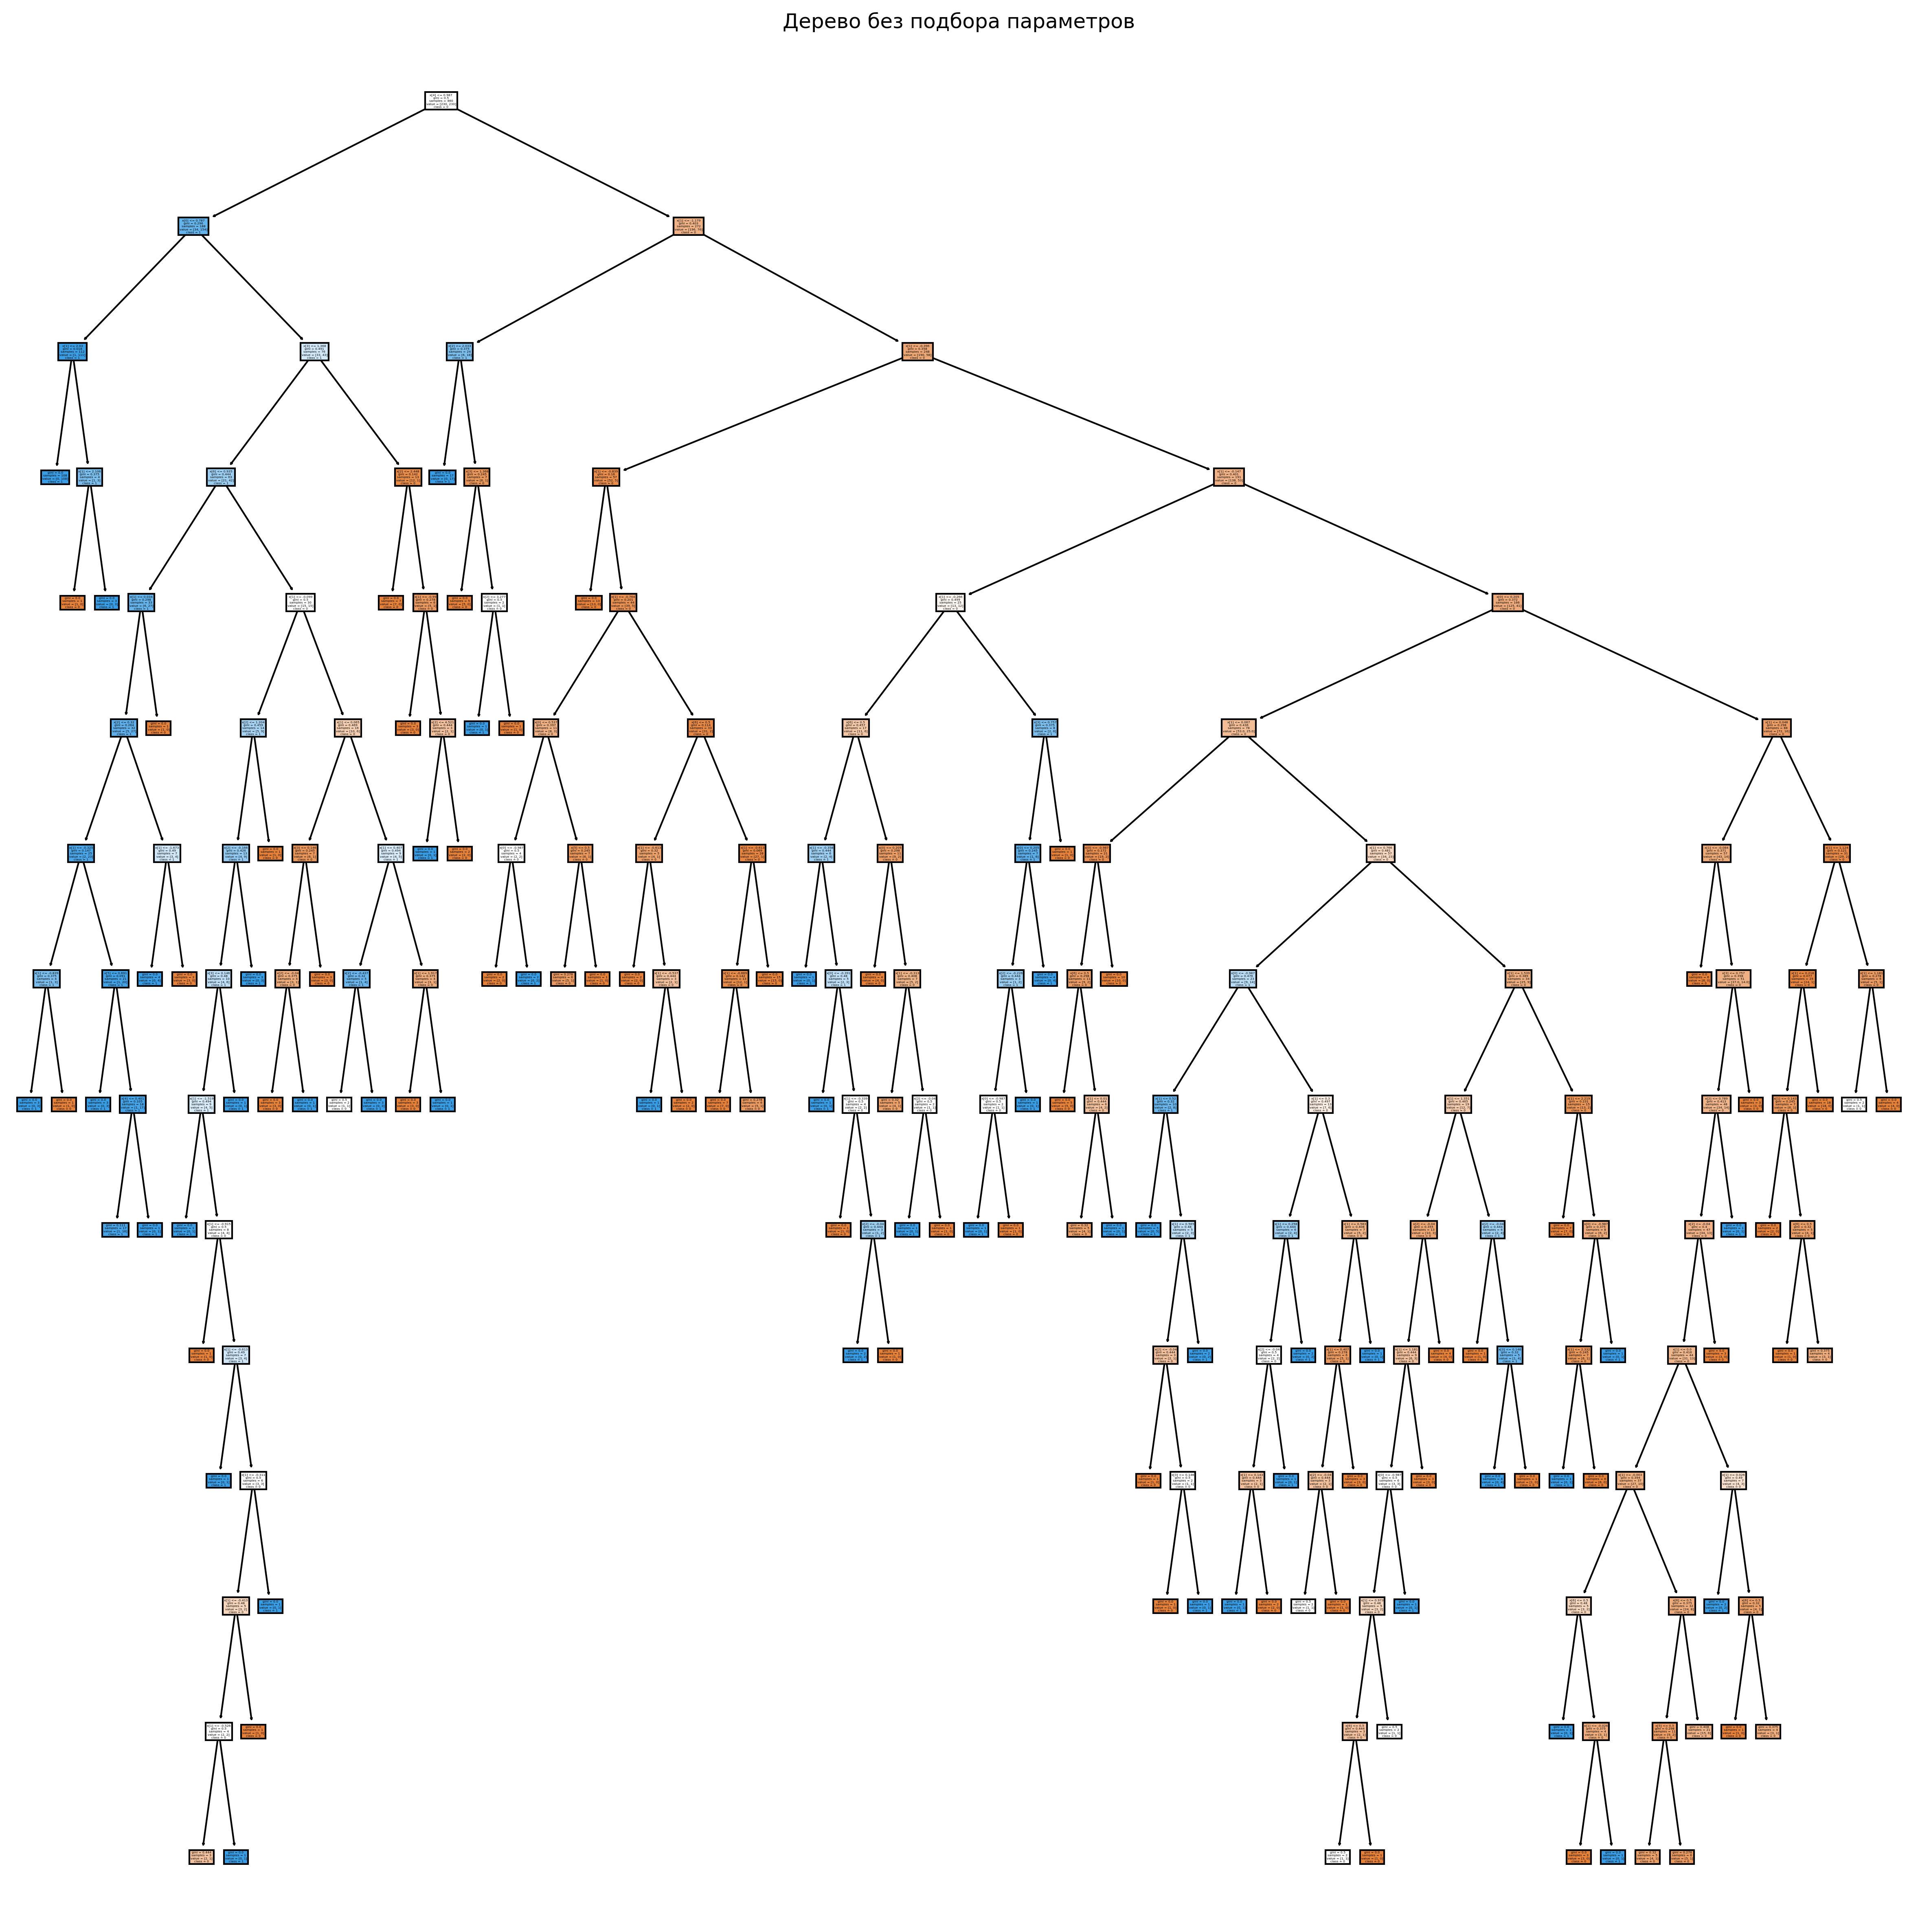

In [16]:
print(f'{tree_accuracy=}')
plt.figure(figsize=(20, 20), dpi=300)
plot_tree(tree, filled=True, class_names=['0', '1'])
plt.title("Дерево без подбора параметров")
plt.show()

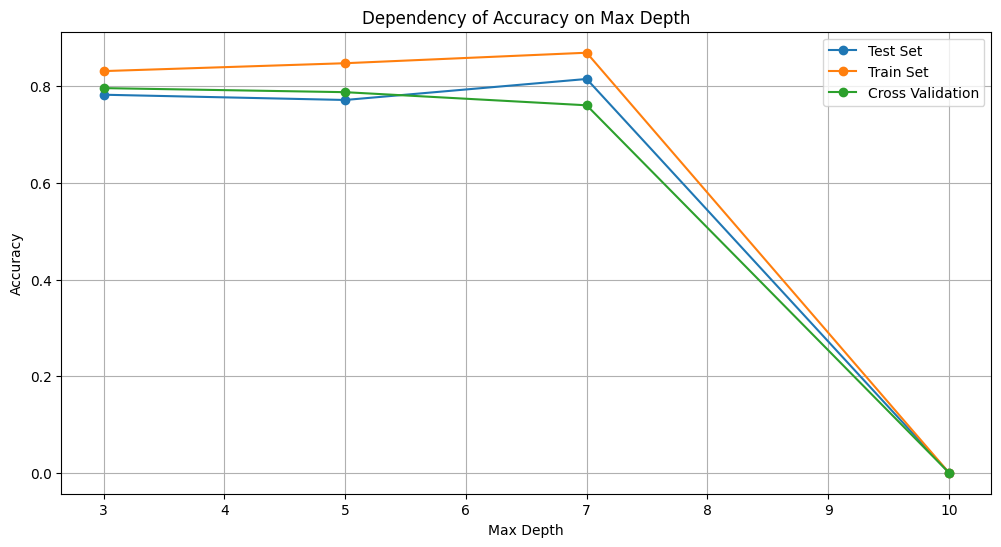

In [16]:
max_depths = [3, 5, 7, 10]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 4]

# Инициализация списков для сохранения результатов
test_scores = [0] * len(max_depths)
train_scores = [0] * len(max_depths)
cv_scores = [0] * len(max_depths)

X_train, x_test, y_train, Y_test = train_test_split(X_train, y_train, test_size=0.2)

# Перебор всех комбинаций параметров
for i, (max_depth, min_samples_split, min_samples_leaf) in enumerate(zip(max_depths, min_samples_splits, min_samples_leafs)):
    # Инициализация модели с текущими параметрами
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    tree_clf.fit(X_train, y_train)
    
    # Оценка качества на тестовой выборке
    test_score = accuracy_score(Y_test, tree_clf.predict(x_test))
    test_scores[i] = test_score
    
    
    train_score = accuracy_score(y_train, tree_clf.predict(X_train))
    train_scores[i] = train_score
    
    # Оценка качества с помощью перекрестной проверки
    cv_score = cross_val_score(tree_clf, X_train, y_train, cv=stratified_k_fold, scoring="accuracy").mean()
    cv_scores[i] = cv_score

plt.figure(figsize=(12, 6))

plt.plot(max_depths, test_scores, marker='o', label='Test Set')
plt.plot(max_depths, train_scores, marker='o', label='Train Set')
plt.plot(max_depths, cv_scores, marker='o', label='Cross Validation')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Dependency of Accuracy on Max Depth')

plt.legend()
plt.grid(True)
plt.show()


In [17]:

# Вывод оптимальных значений параметров
best_idx = np.argmax(cv_scores)
optimal_max_depth = max_depths[best_idx]
optimal_min_samples_split = min_samples_splits[best_idx]
optimal_min_samples_leaf = min_samples_leafs[best_idx]

print("Optimal parameters:")
print(f"Max Depth: {optimal_max_depth}")
print(f"Min Samples Split: {optimal_min_samples_split}")
print(f"Min Samples Leaf: {optimal_min_samples_leaf}")

Optimal parameters:
Max Depth: 3
Min Samples Split: 2
Min Samples Leaf: 1


In [18]:
test_data = pd.read_csv('test.csv', index_col='PassengerId')
id_column = test_data.index
test_data['Age'] = imp.fit_transform(test_data['Age'].values.reshape(-1, 1))

del test_data['Cabin']
test_data.drop(columns=['Name', 'Ticket', 'Fare'], inplace=True)

transformed = one_hot_encoder.fit_transform(test_data[categorical_variables])
encoded = pd.DataFrame(transformed, index=test_data.index)
encoded.columns = one_hot_encoder.get_feature_names_out()
test_data = test_data.join(encoded)
test_data.drop(columns=['Sex', 'Embarked'], inplace=True)

test_data[numeric_variables] = standard_scaler.transform(test_data[numeric_variables])


In [19]:
test_data.drop('Embarked_nan', axis=1, inplace=True)

In [20]:
tree_clf = DecisionTreeClassifier(min_samples_split=optimal_min_samples_split, min_samples_leaf=optimal_min_samples_leaf)
tree_clf.fit(X_train, y_train)
tree_score = accuracy_score(Y_test, tree_clf.predict(x_test))
print(f'Accuracy score дерева до обрезки: {tree_score}')

tree_clf_after_pruning = DecisionTreeClassifier(max_depth=optimal_max_depth, min_samples_split=optimal_min_samples_split, min_samples_leaf=optimal_min_samples_leaf)
tree_clf_after_pruning.fit(X_train, y_train)
tree_score_after_pruning = accuracy_score(Y_test, tree_clf_after_pruning.predict(x_test))
print(f'Accuracy score дерева после обрезки: {tree_score_after_pruning}')

tree_accuracy = accuracy_score(y_train, tree.predict(X_train))
print(f'Точность дерева на тестоввых данных: {tree_accuracy}')

y_pred_test = tree_clf_after_pruning.predict(test_data)
results_df = pd.DataFrame({
    'Survived': y_pred_test
})
results_df.index = test_data.index



Accuracy score дерева до обрезки: 0.8369565217391305
Accuracy score дерева после обрезки: 0.782608695652174
Точность дерева на тестоввых данных: 0.9592391304347826


In [21]:
results_df.to_csv('results.csv')